## <center>Курсовой проект<a class="anchor" id="course_project"></a><center>

### Постановка задачи<a class="anchor" id="course_project_task"></a>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

### Data Analysis

##### Upload of the data and needed libraries

In [1]:
import numpy as np
import pandas as pd
import pickle
import random
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from pylab import rcParams
rcParams["figure.figsize"] = 5, 3
rcParams.update({"font.size": 14})
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')

In [2]:
#input
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

# output
TRAIN_PREPARED_PATH = '../train_prepared_full.csv'
TRAIN_PART_PATH = '../train_part_b.csv'
VALID_PART_PATH = '../valid_part.csv'
SUBMIT_DATASET_PATH = 'VDivak_predictions.csv'

MODEL_FILE_PATH = '../final_model.pkl'
SCALER_FILE_PATH = '../scaler.pkl'

In [3]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

##### Data processing. Filling NaNs

As we can see, some features include NaN. For some of them the NaNs can be filled with mean/mode (Years in current job, Bankruptcies). Some features can be deleted, as they don't represent sufficient information (Months since last deliquent). And for others, which contain significant number of NaNs, mean of meaningful aggregation can be taken. To find that aggregation we need to see the correlation between these factors with others

In [4]:
df.drop(['Months since last delinquent'], axis=1, inplace=True)
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [5]:
df_base = pd.read_csv(TRAIN_DATASET_PATH)

TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_base.columns.drop([TARGET_NAME, 'Months since last delinquent']).tolist()

In [6]:
df['Years in current job_nan'] = 0
df['Years in current job_nan'] = df['Years in current job'].isna() * 1

df['Bankruptcies_nan'] = 0
df['Bankruptcies_nan'] = df['Bankruptcies'].isna() * 1

In [7]:
print(str(df['Years in current job'].value_counts()) + '\n' + str(df['Years in current job'].describe()) + '\n\n' + 
      '*'*100 + '\n\n' + 
      str(df['Bankruptcies'].value_counts()) + '\n' + str(df['Bankruptcies'].describe()))

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
count          7129
unique           11
top       10+ years
freq           2332
Name: Years in current job, dtype: object

****************************************************************************************************

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64
count    7486.000000
mean        0.117152
std         0.347192
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.000000
Name: Bankruptcies, dtype: float64


In [8]:
df['Years in current job'] = df['Years in current job'].fillna(df['Years in current job'].mode()[0])

df['Bankruptcies'] = df['Bankruptcies'].fillna(df['Bankruptcies'].mode()[0])

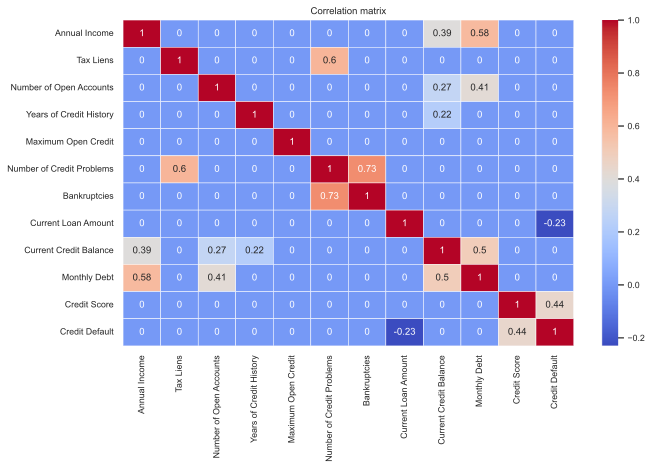

In [9]:
plt.figure(figsize=(9, 6))

sns.set(font_scale=0.8)

corr_matrix = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

Annual income has a significant correlation with Monthly Debt. The following procedure is applied: the monthly debt is turned to category, the medians of Annual Income is found for each group of new category and then these medians are used to fill-in the blanks 

In [10]:
mdebt_cat = pd.cut(df['Monthly Debt'], bins = (df['Monthly Debt'].min()-1,
                                              df['Monthly Debt'].quantile(0.1),
                                              df['Monthly Debt'].quantile(0.2),
                                              df['Monthly Debt'].quantile(0.3),
                                              df['Monthly Debt'].quantile(0.4),
                                              df['Monthly Debt'].quantile(0.5),
                                              df['Monthly Debt'].quantile(0.6),
                                              df['Monthly Debt'].quantile(0.7),
                                              df['Monthly Debt'].quantile(0.8),
                                              df['Monthly Debt'].quantile(0.9),
                                              df['Monthly Debt'].max()+1), labels = False)
mdebt_cat.head()

0    1
1    5
2    3
3    2
4    1
Name: Monthly Debt, dtype: int64

In [11]:
debt_for_nans = df.groupby(mdebt_cat).median()['Annual Income']
debt_for_nans.head()

Monthly Debt
0     765225.0
1     851751.0
2     902652.0
3     959880.0
4    1042729.5
Name: Annual Income, dtype: float64

In [12]:
mdebt_cat.replace(debt_for_nans.index, debt_for_nans, inplace = True)
mdebt_cat.head()

0     851751.0
1    1127887.5
2     959880.0
3     902652.0
4     851751.0
Name: Monthly Debt, dtype: float64

In [13]:
df['Annual Income_nan'] = 0
df['Annual Income_nan'] = df['Annual Income'].isna() * 1

df['Annual Income'] = df['Annual Income'].fillna(mdebt_cat)

In [14]:
df['Annual Income'].isna().sum()

0

Credit score has a strong correlation with Credit default. However, we cannot use Creadit Default as a baseline, as it is our target value and we will artificially increase it's correlation with the target. Herewith, let's look first on the histogram and see if Credit Score (without outliers) is dependent on any distribution.

<AxesSubplot:>

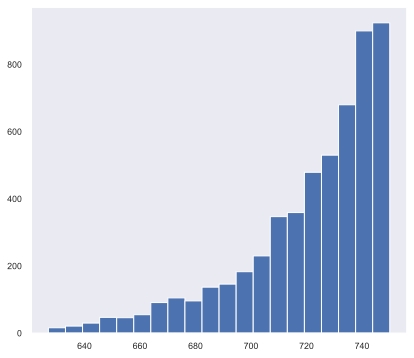

In [15]:
qntl1 = df['Credit Score'].quantile(0.01)
qntl93 = df['Credit Score'].quantile(0.93)
df.loc[(df['Credit Score'] > qntl1) & (df['Credit Score'] < qntl93), 'Credit Score'].hist(figsize=(6, 6), bins=20, grid=False)

The distribution looks very alike to exponential distribution. Therefore, we can create the list of random values, which will follow the exponential distribution and assign those randomlz generated values to the nans in Credit Score

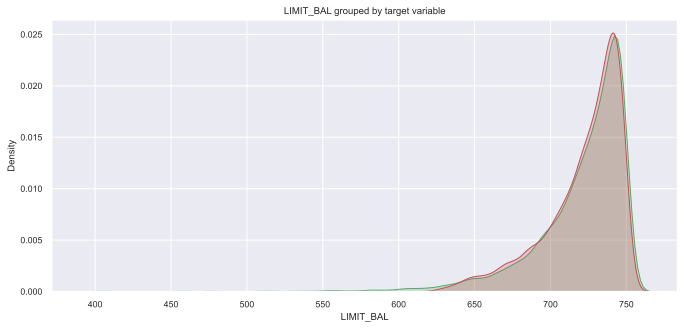

In [16]:
np.random.seed(10)
rand =list(-1*np.random.exponential(scale=30, size=(df.index[-1]+1))+df['Credit Score'].mode()[0]+10)
cred_score = df.loc[(df['Credit Score'] > qntl1) & (df['Credit Score'] < qntl93), 'Credit Score'].sample(5000)

plt.figure(figsize=(10, 5))

sns.kdeplot(rand, shade=True, label='No default', color='g')
sns.kdeplot(cred_score, shade=True, label='Default', color='r')

plt.xlabel('LIMIT_BAL')
plt.title('LIMIT_BAL grouped by target variable')
plt.show()


In [17]:
df['Credit Score_nan'] = 0
df['Credit Score_nan'] = df['Credit Score'].isna() * 1

df['Credit Score'].fillna(pd.Series(rand), inplace = True)

In [18]:
df.isna().sum().sum()

0

##### Data processing. Replacing outliers

In [19]:
pd.set_option('float_format', '{:f}'.format)

In [20]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Years in current job_nan,Bankruptcies_nan,Annual Income_nan,Credit Score_nan
count,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,1333978.431533,0.030133,11.130933,18.317467,945153.727467,0.170000,0.116933,11873177.445067,289833.235200,18314.454133,1061.803536,0.281733,0.049467,0.001867,0.207600,0.207600
std,777409.303447,0.271604,4.908924,7.041946,16026216.670852,0.498598,0.346904,31926122.974729,317871.382380,11926.764673,1438.885271,0.449874,0.216855,0.043167,0.405616,0.405616
min,164597.000000,0.000000,2.000000,4.000000,0.000000,0.000000,0.000000,11242.000000,0.000000,0.000000,457.977550,0.000000,0.000000,0.000000,0.000000,0.000000
25%,855940.500000,0.000000,8.000000,13.500000,279229.500000,0.000000,0.000000,180169.000000,114256.500000,10067.500000,711.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1143439.000000,0.000000,10.000000,17.000000,478159.000000,0.000000,0.000000,309573.000000,209323.000000,16076.500000,731.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1603372.000000,0.000000,14.000000,21.800000,793501.500000,0.000000,0.000000,519882.000000,360406.250000,23818.000000,742.931217,1.000000,0.000000,0.000000,0.000000,0.000000
max,10149344.000000,7.000000,43.000000,57.700000,1304726170.000000,7.000000,4.000000,99999999.000000,6506797.000000,136679.000000,7510.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We see some clear anomalies with the following parameters: Annual Income, Maximum Open Credit, Current Loan Amount, Current Credit Balance, Monthly Debt, Credit Score. For these parameters we eliminate outliners that lie out of special quantiles with the random values, that lies between 0.25 and 0.75 quantiles.

In [21]:
for col in ('Annual Income', 'Maximum Open Credit', 'Current Loan Amount', 
            'Current Credit Balance', 'Monthly Debt', 'Credit Score'):
    print(col + '\n' + 'min - ' + str(df[col].min()) + 
          '\n' + 'q025 - ' + str(df[col].quantile(0.025)) + 
          '\n' + 'q975 - ' + str(df[col].quantile(0.975)) + 
          '\n' + 'max - ' + str(df[col].max()) +'\n\n')

Annual Income
min - 164597.0
q025 - 465657.7
q975 - 3201582.6499999985
max - 10149344.0


Maximum Open Credit
min - 0.0
q025 - 70912.60000000002
q975 - 2236204.2999999984
max - 1304726170.0


Current Loan Amount
min - 11242.0
q025 - 57750.55000000001
q975 - 99999999.0
max - 99999999.0


Current Credit Balance
min - 0.0
q025 - 11970.0
q975 - 1001579.7749999975
max - 6506797.0


Monthly Debt
min - 0.0
q025 - 2433.95
q975 - 47950.149999999965
max - 136679.0


Credit Score
min - 457.97755048095775
q025 - 647.0
q975 - 7215.249999999996
max - 7510.0




In [22]:
for col in ('Annual Income', 'Maximum Open Credit', 'Current Loan Amount', 
            'Current Credit Balance', 'Monthly Debt', 'Credit Score'):
    df[col+'_outlier'] = 0
    condition = ((df[col] < df[col].quantile(0.025)) | (df[col] > df[col].quantile(0.925)))
    df.loc[condition, col + '_outlier'] = 1
    df.loc[condition, col] = np.random.randint(df[col].quantile(0.25), df[col].quantile(0.75), size = len(df.loc[condition, col]))

In [23]:
for col in ('Annual Income', 'Maximum Open Credit', 'Current Loan Amount', 
            'Current Credit Balance', 'Monthly Debt', 'Credit Score'):
    print(col + '\n' + 'min - ' + str(df[col].min()) + 
          '\n' + 'q025 - ' + str(df[col].quantile(0.025)) + 
          '\n' + 'q975 - ' + str(df[col].quantile(0.975)) + 
          '\n' + 'max - ' + str(df[col].max()) +'\n\n')

Annual Income
min - 465937.0
q025 - 561015.375
q975 - 2172422.0
max - 2309868.0


Maximum Open Credit
min - 71236.0
q025 - 111628.0
q975 - 1245558.0499999998
max - 1432310.0


Current Loan Amount
min - 57970.0
q025 - 76206.9
q975 - 99999999.0
max - 99999999.0


Current Credit Balance
min - 11970.0
q025 - 29592.025
q975 - 596926.7999999999
max - 663404.0


Monthly Debt
min - 2435.0
q025 - 3688.275
q975 - 32982.525
max - 36243.0


Credit Score
min - 647.0
q025 - 665.0
q975 - 748.0
max - 749.8812270770433




In [24]:
df['Current Loan Amount'].value_counts().head()

99999999.000000    870
218064.000000        6
89298.000000         6
265826.000000        5
216106.000000        5
Name: Current Loan Amount, dtype: int64

In [25]:
df.loc[df['Current Loan Amount'] == 99999999,'Current Loan Amount_outlier'] = 1
df.loc[df['Current Loan Amount'] == 99999999,'Current Loan Amount'] = np.random.randint(
                        df['Current Loan Amount'].quantile(0.25), df['Current Loan Amount'].quantile(0.75), 
                        size = len(df.loc[df['Current Loan Amount'] == 99999999,'Current Loan Amount']))

array([[<AxesSubplot:title={'center':'Annual Income'}>,
        <AxesSubplot:title={'center':'Tax Liens'}>,
        <AxesSubplot:title={'center':'Number of Open Accounts'}>],
       [<AxesSubplot:title={'center':'Years of Credit History'}>,
        <AxesSubplot:title={'center':'Maximum Open Credit'}>,
        <AxesSubplot:title={'center':'Number of Credit Problems'}>],
       [<AxesSubplot:title={'center':'Bankruptcies'}>,
        <AxesSubplot:title={'center':'Current Loan Amount'}>,
        <AxesSubplot:title={'center':'Current Credit Balance'}>],
       [<AxesSubplot:title={'center':'Monthly Debt'}>,
        <AxesSubplot:title={'center':'Credit Score'}>,
        <AxesSubplot:title={'center':'Credit Default'}>]], dtype=object)

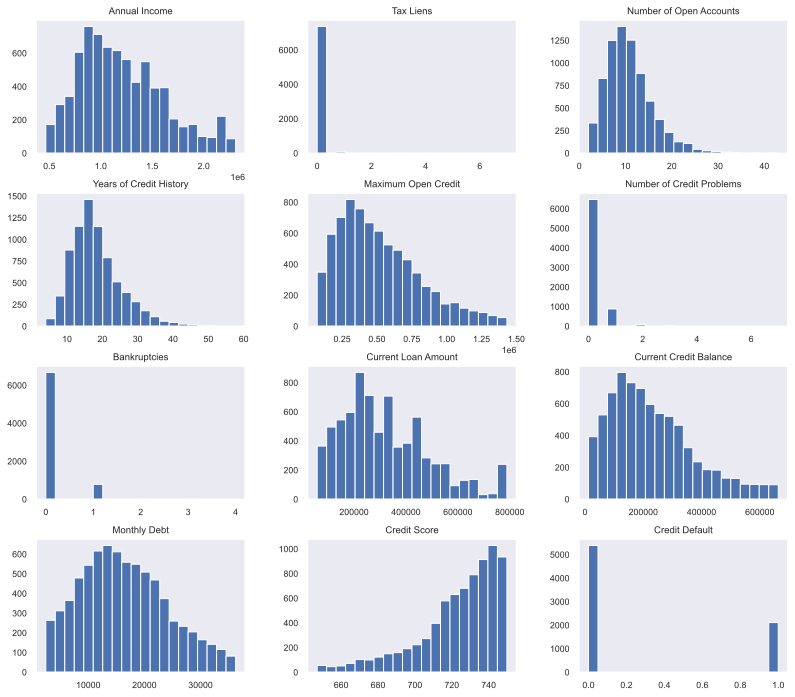

In [26]:
add_features = pd.concat([df.filter(like='nan'), df.filter(like='outlier')], axis = 1)
df_num_features = df.drop(add_features.columns.tolist(), axis = 1)
df_num_features.hist(figsize=(12, 12), bins=20, grid=False)

In [27]:
class DataPreprocessing:
    """Preprocessing of the initial data"""

    def __init__(self):
        """Parameters of the class"""
        self.modes = None
        self.medians = None
        self.mdebt_cat = None
        self.debt_for_nans = None
        self.index = None
        self.qntl0025 = None
        self.qntl0975 = None
        self.qntl025 = None
        self.qntl075 = None
        
    def fit(self, X):
        """Saving the statistics"""       
        # Calculation of statistics
        self.modes = X.mode()
        self.medians = X.median()
        self.mdebt_cat = pd.cut(df['Monthly Debt'], bins = (df['Monthly Debt'].min()-1,
                                              df['Monthly Debt'].quantile(0.1),
                                              df['Monthly Debt'].quantile(0.2),
                                              df['Monthly Debt'].quantile(0.3),
                                              df['Monthly Debt'].quantile(0.4),
                                              df['Monthly Debt'].quantile(0.5),
                                              df['Monthly Debt'].quantile(0.6),
                                              df['Monthly Debt'].quantile(0.7),
                                              df['Monthly Debt'].quantile(0.8),
                                              df['Monthly Debt'].quantile(0.9),
                                              df['Monthly Debt'].max()+1), labels = False)
        self.debt_for_nans = X.groupby(self.mdebt_cat).median()['Annual Income']
        self.mdebt_cat.replace(self.debt_for_nans.index, self.debt_for_nans, inplace = True)
        self.index = X.index[-1]+1
        self.qntl0025 = X.quantile(0.025)
        self.qntl0975 = X.quantile(0.975)
        self.qntl025 = X.quantile(0.25)
        self.qntl075 = X.quantile(0.75)

    
    def transform(self, X):
        """Transformation of data"""
        
        #Drop of insignificant parameter
        X.drop(['Months since last delinquent'], axis=1, inplace=True)
        
        #Years in current job and Bunkruptcies
        X['Years in current job_nan'] = 0
        X['Years in current job_nan'] = X['Years in current job'].isna() * 1

        X['Bankruptcies_nan'] = 0
        X['Bankruptcies_nan'] = X['Bankruptcies'].isna() * 1
        
        X['Years in current job'] = X['Years in current job'].fillna(self.modes['Years in current job'][0])
        X['Bankruptcies'] = X['Bankruptcies'].fillna(self.modes['Bankruptcies'][0])
        
        #Annual Income
        X['Annual Income_nan'] = 0
        X['Annual Income_nan'] = X['Annual Income'].isna() * 1

        X['Annual Income'] = X['Annual Income'].fillna(self.mdebt_cat)
        
        #Credit Score
        np.random.seed(10)
        rand =list(-1*np.random.exponential(scale=30, size=(self.index))+self.modes['Credit Score'][0]+10)

        X['Credit Score_nan'] = 0
        X['Credit Score_nan'] = X['Credit Score'].isna() * 1

        X['Credit Score'].fillna(pd.Series(rand), inplace = True)
        
        #Outliers
        
        for col in ('Annual Income', 'Maximum Open Credit', 'Current Loan Amount', 
            'Current Credit Balance', 'Monthly Debt', 'Credit Score'):
            X[col+'_outlier'] = 0
            condition = ((X[col] < self.qntl0025[col]) | (X[col] > self.qntl0975[col]))
            X.loc[condition, col + '_outlier'] = 1
            X.loc[condition, col] = np.random.randint(self.qntl025[col], self.qntl075[col], size = len(X.loc[condition, col]))
            
        #Current Loan Amount  
        X.loc[X['Current Loan Amount'] == 99999999,'Current Loan Amount_outlier'] = 1
        X.loc[X['Current Loan Amount'] == 99999999,'Current Loan Amount'] = np.random.randint(
                                self.qntl025['Current Loan Amount'], self.qntl075['Current Loan Amount'], 
                                size = len(X.loc[X['Current Loan Amount'] == 99999999,'Current Loan Amount']))
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

##### Data processing. Generation of new features

Feature encoding

Tax Liens contains several values and from the description is more a category than a real number feature

In [28]:
df['Tax Liens'].astype('object')

0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
7495   0.000000
7496   0.000000
7497   0.000000
7498   0.000000
7499   0.000000
Name: Tax Liens, Length: 7500, dtype: object

Term has only 2 values, which identifies that the feature can be turned to boolean

In [29]:
df['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

In [30]:
df['Term'] = df['Term'].replace({'Short Term': 0, 'Long Term': 1})

Category feature encoding by getting dummies from the values

In [31]:
df = pd.concat([df, pd.get_dummies(df.select_dtypes(include=['object']))], axis=1)
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,...,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
0,Own Home,482087.000000,10+ years,0.000000,11.000000,26.300000,685960.000000,1.000000,1.000000,debt consolidation,...,0,0,0,0,0,0,0,0,0,0
1,Own Home,1025487.000000,10+ years,0.000000,15.000000,15.300000,1181730.000000,0.000000,0.000000,debt consolidation,...,0,0,0,0,0,0,0,0,0,0
2,Home Mortgage,751412.000000,8 years,0.000000,11.000000,35.000000,1182434.000000,0.000000,0.000000,debt consolidation,...,0,0,0,0,0,0,0,0,0,0
3,Own Home,805068.000000,6 years,0.000000,8.000000,22.500000,147400.000000,1.000000,1.000000,debt consolidation,...,0,0,0,0,0,0,0,0,0,0
4,Rent,776264.000000,8 years,0.000000,13.000000,13.600000,385836.000000,1.000000,0.000000,debt consolidation,...,0,0,0,0,0,0,0,0,0,0


Monthly debt is turned to category feature, based on the quantiles

In [32]:
mdebt_cat = pd.cut(df['Monthly Debt'], bins = (df['Monthly Debt'].min()-1,
                                              df['Monthly Debt'].quantile(0.1),
                                              df['Monthly Debt'].quantile(0.2),
                                              df['Monthly Debt'].quantile(0.3),
                                              df['Monthly Debt'].quantile(0.4),
                                              df['Monthly Debt'].quantile(0.5),
                                              df['Monthly Debt'].quantile(0.6),
                                              df['Monthly Debt'].quantile(0.7),
                                              df['Monthly Debt'].quantile(0.8),
                                              df['Monthly Debt'].quantile(0.9),
                                              df['Monthly Debt'].max()+1), labels = False)
df['Monthly_debt_cat'] = mdebt_cat

For Number of Credit Problems and Bankruptcies one value prevails over others (0). Therefore, we can turn this features to boolean

In [33]:
df['Number of Credit Problems_bool'] = 0
df.loc[df['Number of Credit Problems'] > 0, 'Number of Credit Problems_bool'] = 1

In [34]:
df['Bankruptcies_bool'] = 0
df.loc[df['Bankruptcies'] > 0, 'Bankruptcies_bool'] = 1

More advanced categories can be created based on the median values grouped by some other features. One feature is generated based on the median loan amount that is grouped in loan purpose and debt category. The other feature represents medium annual income based on credit score and open accounts

In [35]:
medloan_by_debt = df.groupby(['Purpose', 'Monthly_debt_cat'], as_index=False)\
                            .agg({'Current Loan Amount':'median'}).rename(columns={'Current Loan Amount':'Med_loan_by_debt'})

df = df.merge(medloan_by_debt, on=['Purpose', 'Monthly_debt_cat'], how='left')
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,...,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Monthly_debt_cat,Number of Credit Problems_bool,Bankruptcies_bool,Med_loan_by_debt
0,Own Home,482087.000000,10+ years,0.000000,11.000000,26.300000,685960.000000,1.000000,1.000000,debt consolidation,...,0,0,0,0,0,0,1,1,1,225830.000000
1,Own Home,1025487.000000,10+ years,0.000000,15.000000,15.300000,1181730.000000,0.000000,0.000000,debt consolidation,...,0,0,0,0,0,0,6,0,0,333762.000000
2,Home Mortgage,751412.000000,8 years,0.000000,11.000000,35.000000,1182434.000000,0.000000,0.000000,debt consolidation,...,0,0,0,0,0,0,3,0,0,261624.000000
3,Own Home,805068.000000,6 years,0.000000,8.000000,22.500000,147400.000000,1.000000,1.000000,debt consolidation,...,0,0,0,0,0,0,2,1,1,258698.000000
4,Rent,776264.000000,8 years,0.000000,13.000000,13.600000,385836.000000,1.000000,0.000000,debt consolidation,...,0,0,0,0,0,0,1,1,0,225830.000000


In [36]:
medincome_by_score = df.groupby(['Credit Score', 'Number of Open Accounts'], as_index=False)\
                            .agg({'Annual Income':'median'}).rename(columns={'Annual Income':'Med_income_by_score'})

df = df.merge(medincome_by_score, on=['Credit Score', 'Number of Open Accounts'], how='left')
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,...,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Monthly_debt_cat,Number of Credit Problems_bool,Bankruptcies_bool,Med_loan_by_debt,Med_income_by_score
0,Own Home,482087.000000,10+ years,0.000000,11.000000,26.300000,685960.000000,1.000000,1.000000,debt consolidation,...,0,0,0,0,0,1,1,1,225830.000000,1213036.000000
1,Own Home,1025487.000000,10+ years,0.000000,15.000000,15.300000,1181730.000000,0.000000,0.000000,debt consolidation,...,0,0,0,0,0,6,0,0,333762.000000,1017146.000000
2,Home Mortgage,751412.000000,8 years,0.000000,11.000000,35.000000,1182434.000000,0.000000,0.000000,debt consolidation,...,0,0,0,0,0,3,0,0,261624.000000,1261524.000000
3,Own Home,805068.000000,6 years,0.000000,8.000000,22.500000,147400.000000,1.000000,1.000000,debt consolidation,...,0,0,0,0,0,2,1,1,258698.000000,805068.000000
4,Rent,776264.000000,8 years,0.000000,13.000000,13.600000,385836.000000,1.000000,0.000000,debt consolidation,...,0,0,0,0,0,1,1,0,225830.000000,921258.000000


In [37]:
class FeatureGenetator():
    """Generation of the new features"""
    
    def __init__(self):
        
        self.binary_to_numbers = None
        self.mdebt_cat = None
        self.medloan_by_debt = None
        self.medloan_by_debt_median = None
        self.medincome_by_score = None
        self.medincome_by_score_median = None

    def debt_to_cat(self, X):
        X['Monthly_debt_cat'] = self.mdebt_cat

        X['Monthly_debt_cat'].fillna(-1, inplace=True)
        return X
        
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'Short Term': 0, 'Long Term': 1}
        
        #Medium debt category
        self.mdebt_cat = pd.cut(X['Monthly Debt'], bins = (X['Monthly Debt'].min()-1,
                                              X['Monthly Debt'].quantile(0.1),
                                              X['Monthly Debt'].quantile(0.2),
                                              X['Monthly Debt'].quantile(0.3),
                                              X['Monthly Debt'].quantile(0.4),
                                              X['Monthly Debt'].quantile(0.5),
                                              X['Monthly Debt'].quantile(0.6),
                                              X['Monthly Debt'].quantile(0.7),
                                              X['Monthly Debt'].quantile(0.8),
                                              X['Monthly Debt'].quantile(0.9),
                                              X['Monthly Debt'].max()+1), labels = False)
        
        #Features encoding
        
        df = X.copy()
        
        df['Monthly_debt_cat'] = self.mdebt_cat
        df['Monthly_debt_cat'].fillna(-1, inplace=True)
        
        
        self.medloan_by_debt = df.groupby(['Purpose', 'Monthly_debt_cat'], as_index=False)\
                            .agg({'Current Loan Amount':'median'}).rename(columns={'Current Loan Amount':'Med_loan_by_debt'})
        self.medloan_by_debt_median = self.medloan_by_debt['Med_loan_by_debt'].median()
        
        self.medincome_by_score = df.groupby(['Credit Score', 'Number of Open Accounts'], as_index=False)\
                            .agg({'Annual Income':'median'}).rename(columns={'Annual Income':'Med_income_by_score'})
        self.medincome_by_score_median = self.medincome_by_score['Med_income_by_score'].median()

        
    def transform(self, X):
        
        #Tax Liens
        X['Tax Liens'].astype('object')
        
        # Binary features
        X['Term'] = X['Term'].replace(self.binary_to_numbers)
        
        #Category features encoding
        X = pd.concat([X, pd.get_dummies(X.select_dtypes(include=['object']))], axis=1)
        
        #Monthly Debt cat
        X['Monthly_debt_cat'] = self.mdebt_cat
        X['Monthly_debt_cat'].fillna(-1, inplace=True)
        
        #Boolean Features
        X['Number of Credit Problems_bool'] = 0
        X.loc[df['Number of Credit Problems'] > 0, 'Number of Credit Problems_bool'] = 1
        
        X['Bankruptcies_bool'] = 0
        X.loc[X['Bankruptcies'] > 0, 'Bankruptcies_bool'] = 1
        
        #Median grouping
        X = X.merge(self.medloan_by_debt, on=['Purpose', 'Monthly_debt_cat'], how='left')
        X['Med_loan_by_debt'].fillna(self.medloan_by_debt_median, inplace=True)
        
        X = X.merge(self.medincome_by_score, on=['Credit Score', 'Number of Open Accounts'], how='left')
        X['Med_income_by_score'].fillna(self.medincome_by_score_median, inplace=True)
        
        return X

### Model Creation

In [38]:
#!pip install xgboost
#!pip install lightgbm
#!pip install catboost

In [39]:
import re
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

In [40]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [41]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) -1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [42]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = pd.Categorical(df[col])

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

##### Selection of the features, preprocessing

In [43]:
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES).tolist()
CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job',  'Purpose']

NUM_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + CAT_FEATURE_NAMES).tolist()

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + NEW_FEATURE_NAMES

In [44]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=TARGET_NAME)
y = train_df[TARGET_NAME]

In [45]:
preprocessor = DataPreprocessing()
preprocessor.fit(X)

X = preprocessor.transform(X)
test_df = preprocessor.transform(test_df)

X.shape, test_df.shape

((7500, 25), (2500, 25))

In [46]:
features_gen = FeatureGenetator()
features_gen.fit(X, y)

X = features_gen.transform(X)
test_df = features_gen.transform(test_df)

X.shape, test_df.shape

((7500, 60), (2500, 59))

As number of features are not equall in X and test_df, the outlied feature must be deleted

In [47]:
X.columns.drop(test_df.columns.tolist())

Index(['Purpose_renewable energy'], dtype='object')

In [48]:
X = X.drop(['Purpose_renewable energy'], axis=1)

In [49]:
X.shape, test_df.shape

((7500, 59), (2500, 59))

In [50]:
NEW_FEATURE_NAMES.remove('Purpose_renewable energy')
SELECTED_FEATURE_NAMES.remove('Purpose_renewable energy')
X = X[BASE_FEATURE_NAMES + NEW_FEATURE_NAMES].drop(columns = CAT_FEATURE_NAMES)
test_df = test_df[BASE_FEATURE_NAMES + NEW_FEATURE_NAMES].drop(columns = CAT_FEATURE_NAMES)

In [51]:
X.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0)

##### Scaling the datasets

In [52]:
reduce_mem_usage(X), reduce_mem_usage(test_df)

Memory usage of dataframe is 1.70 MB
Memory usage after optimization is: 1.36 MB
Decreased by 19.8%
Memory usage of dataframe is 0.57 MB
Memory usage after optimization is: 0.45 MB
Decreased by 19.8%


(      Annual Income  Tax Liens  Number of Open Accounts  \
 0     482087.000000   0.000000                11.000000   
 1    1025487.000000   0.000000                15.000000   
 2     751412.000000   0.000000                11.000000   
 3     805068.000000   0.000000                 8.000000   
 4     776264.000000   0.000000                13.000000   
 ...             ...        ...                      ...   
 7495 1466849.000000   0.000000                 3.000000   
 7496 1533984.000000   0.000000                10.000000   
 7497 1878910.000000   0.000000                12.000000   
 7498 1004948.000000   0.000000                21.000000   
 7499  855171.000000   0.000000                 8.000000   
 
       Years of Credit History  Maximum Open Credit  Number of Credit Problems  \
 0                   26.299999        685960.000000                   1.000000   
 1                   15.300000       1181730.000000                   0.000000   
 2                   35.000000  

In [53]:
feature_names_for_stand = X.select_dtypes(include=['float64', 'float32', 'float16', 'int8', 'int16', 'int32', 'int64']).columns.tolist()

In [54]:
scaler = StandardScaler()

stand_features_train = scaler.fit_transform(X[feature_names_for_stand])
stand_features_test = scaler.transform(test_df[feature_names_for_stand])

In [55]:
X[feature_names_for_stand] = stand_features_train
test_df[feature_names_for_stand] = stand_features_test

In [56]:
X.head()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Term,Current Loan Amount,Current Credit Balance,...,Purpose_other,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Monthly_debt_cat,Number of Credit Problems_bool,Bankruptcies_bool,Med_loan_by_debt,Med_income_by_score
0,-1.493912,-0.110953,-0.026674,1.133645,0.253700,1.664779,2.545732,-0.591517,0.645247,-1.120200,...,-0.311919,-0.058981,-0.070412,-0.032677,-0.044766,-1.218544,2.504893,2.842517,-0.940484,-0.016290
1,-0.468028,-0.110953,0.788223,-0.428528,1.495785,-0.340979,-0.337099,1.690569,-0.332389,0.706815,...,-0.311919,-0.058981,-0.070412,-0.032677,-0.044766,0.174078,-0.399219,-0.351801,0.264466,-0.530956
2,-0.985453,-0.110953,-0.026674,2.369181,1.497549,-0.340979,-0.337099,-0.591517,-0.376354,0.251709,...,-0.311919,-0.058981,-0.070412,-0.032677,-0.044766,-0.522233,-0.399219,-0.351801,-0.526275,0.096540
3,-0.884156,-0.110953,-0.637847,0.593985,-1.095590,1.664779,2.545732,-0.591517,-1.174903,-0.865433,...,-0.311919,-0.058981,-0.070412,-0.032677,-0.044766,-0.870388,2.504893,2.842517,-0.573130,-1.231277
4,-0.938535,-0.110953,0.380774,-0.669954,-0.498220,1.664779,-0.337099,-0.591517,-1.148825,-0.878815,...,-0.311919,-0.058981,-0.070412,-0.032677,-0.044766,-1.218544,2.504893,-0.351801,-0.940484,-1.161989


In [57]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

##### Train/test separation. Balancing of the target values

In [58]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [59]:
y_train.value_counts()

0    3795
1    1455
Name: Credit Default, dtype: int64

In [60]:
y_index0 = y_train.copy()
y_index0 = y_index0.reset_index()['Credit Default']
X_index0 = X_train.copy()
X_index0 = X_index0.reset_index().drop(columns = 'index')

df_for_balancing = pd.concat([X_index0, y_index0], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)

df_balanced[TARGET_NAME].value_counts()

0    3795
1    2910
Name: Credit Default, dtype: int64

In [61]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

In [62]:
train = pd.concat([X_train, y_train], axis=1)
y_v_index0 = y_valid.copy()
y_v_index0 = y_v_index0.reset_index()['Credit Default']
valid = pd.concat([X_valid, y_v_index0], axis=1)
train_full_df = pd.concat([train, valid], axis=0)

In [63]:
train_full_df.to_csv(TRAIN_PREPARED_PATH, index=False, encoding='utf-8')
train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
valid.to_csv(VALID_PART_PATH, index=False, encoding='utf-8')

##### Describtion of the model (Catboost)

In [64]:
model_catb = catb.CatBoostClassifier(class_weights = [1, 1.5], n_estimators = 1000, max_depth = 5, l2_leaf_reg=10, 
                                     silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_valid_pred = model_catb.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.93      0.85      0.89      3795
           1       0.82      0.92      0.87      2910

    accuracy                           0.88      6705
   macro avg       0.88      0.88      0.88      6705
weighted avg       0.88      0.88      0.88      6705

TEST

              precision    recall  f1-score   support

           0       0.82      0.72      0.77      1592
           1       0.48      0.61      0.54       658

    accuracy                           0.69      2250
   macro avg       0.65      0.67      0.65      2250
weighted avg       0.72      0.69      0.70      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1150  442
1                254  404


In [65]:
final_model = catb.CatBoostClassifier(class_weights = [1, 1.5], n_estimators = 1000, max_depth = 5, l2_leaf_reg=10, 
                                     silent=True, random_state=21)

with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

In [66]:
final_model.fit(X, y)

predictions = final_model.predict(test_df)
test_df['Credit Default'] = predictions

test_df.to_csv(SUBMIT_DATASET_PATH, index=False)